# Semi-Supervised Learning Pipeline for Weld Quality Classification

This notebook implements a semi-supervised learning pipeline that:
1. Loads pre-processed data (PCA or clean features)
2. Converts continuous target values into quality classes (Bad, Medium, Good)
3. Trains semi-supervised models (Label Propagation, Label Spreading)
4. Uses propagated labels to train a Random Forest classifier
5. Evaluates all models on validation and test sets

In [6]:
# Import required libraries
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

from semi_supervised.loader import load_data, TARGET_COLS

## 1. Data Loading

In [12]:
# ========================================
# CONFIGURATION
# ========================================

TARGET_NAME = "yield_strength_MPa"  # Change this to test different targets
DATA_VERSION = "pca"  # Options: "pca" or "clean"

In [13]:
# Load data using the new loader
# Specify base_path explicitly since we're in a notebook
from pathlib import Path

# Get the project root (go up from src/semi_supervised/)
project_root = Path.cwd().parent.parent if 'semi_supervised' in str(Path.cwd()) else Path.cwd()
base_path = project_root / "data" / "data_splits"

print(f"Project root: {project_root}")
print(f"Data path: {base_path}")

train, val, test = load_data(TARGET_NAME, data_version=DATA_VERSION, base_path=str(base_path))

if train is None:
    raise ValueError("Failed to load data. Check if files exist.")

X_train, y_train = train
X_val, y_val = val
X_test, y_test = test

print(f"\n--> Data loaded successfully for {TARGET_NAME}")

Project root: c:\Users\Ouissal\weld-quality
Data path: c:\Users\Ouissal\weld-quality\data\data_splits
Loading PCA data for target: yield_strength_MPa
Data directory: c:\Users\Ouissal\weld-quality\data\data_splits\yield_strength_MPa
==> Data loaded successfully:
  Train: X=(1340, 19), y=(1340,)
  Val:   X=(156, 19), y=(156,)
  Test:  X=(156, 19), y=(156,)
  Features: 19
--> No missing values detected

--> Data loaded successfully for yield_strength_MPa


In [15]:
# Convert continuous values to classes

def convert_to_quality_classes_tertiles(y_train, y_val, y_test):
    """
    Convert continuous target values to quality classes using tertiles.
    Uses only LABELED training data to compute thresholds.
    
    Classes:
    - 0: Bad quality (bottom third, < 33.3 percentile)
    - 1: Medium quality (middle third, 33.3-66.6 percentile)
    - 2: Good quality (top third, > 66.6 percentile)
    - -1: Unlabeled (for semi-supervised learning)
    """
    # Get labeled training data to compute thresholds
    labeled_y_train = y_train.dropna()
    
    if len(labeled_y_train) == 0:
        raise ValueError("No labeled training data available to compute thresholds!")
    
    # Compute tertile thresholds (33.3% and 66.6%)
    threshold_low = labeled_y_train.quantile(1/3)
    threshold_high = labeled_y_train.quantile(2/3)
    
    print(f"\nComputed thresholds from labeled training data:")
    print(f"  Bad/Medium boundary (33.3%):   {threshold_low:.2f}")
    print(f"  Medium/Good boundary (66.6%):  {threshold_high:.2f}")
    print(f"  Based on {len(labeled_y_train)} labeled samples")
    
    def classify(y):
        """Apply classification to any dataset"""
        y_classes = pd.Series(index=y.index, dtype=int)
        
        # Check for NaN values (unlabeled data)
        unlabeled_mask = y.isna()
        
        # Classify labeled data
        y_classes[~unlabeled_mask & (y < threshold_low)] = 0  # Bad
        y_classes[~unlabeled_mask & (y >= threshold_low) & (y < threshold_high)] = 1  # Medium
        y_classes[~unlabeled_mask & (y >= threshold_high)] = 2  # Good
        
        # Mark unlabeled data with -1
        y_classes[unlabeled_mask] = -1
        
        return y_classes
    
    # Apply classification to all datasets
    y_train_classes = classify(y_train)
    y_val_classes = classify(y_val)
    y_test_classes = classify(y_test)
    
    return y_train_classes, y_val_classes, y_test_classes, threshold_low, threshold_high


# Convert targets to classes using tertiles
print("\n" + "=" * 70)
print("CONVERTING CONTINUOUS VALUES TO QUALITY CLASSES")
print("=" * 70)
print("Strategy: Data-driven tertiles (33.3% / 66.6% percentiles)")

y_train_classes, y_val_classes, y_test_classes, threshold_low, threshold_high = \
    convert_to_quality_classes_tertiles(y_train, y_val, y_test)


CONVERTING CONTINUOUS VALUES TO QUALITY CLASSES
Strategy: Data-driven tertiles (33.3% / 66.6% percentiles)

Computed thresholds from labeled training data:
  Bad/Medium boundary (33.3%):   463.67
  Medium/Good boundary (66.6%):  533.33
  Based on 468 labeled samples



Class distribution in LABELED training data:
  Bad (0):       156 samples (33.3%)
  Medium (1):    156 samples (33.3%)
  Good (2):      156 samples (33.3%)
  Unlabeled:     872 samples


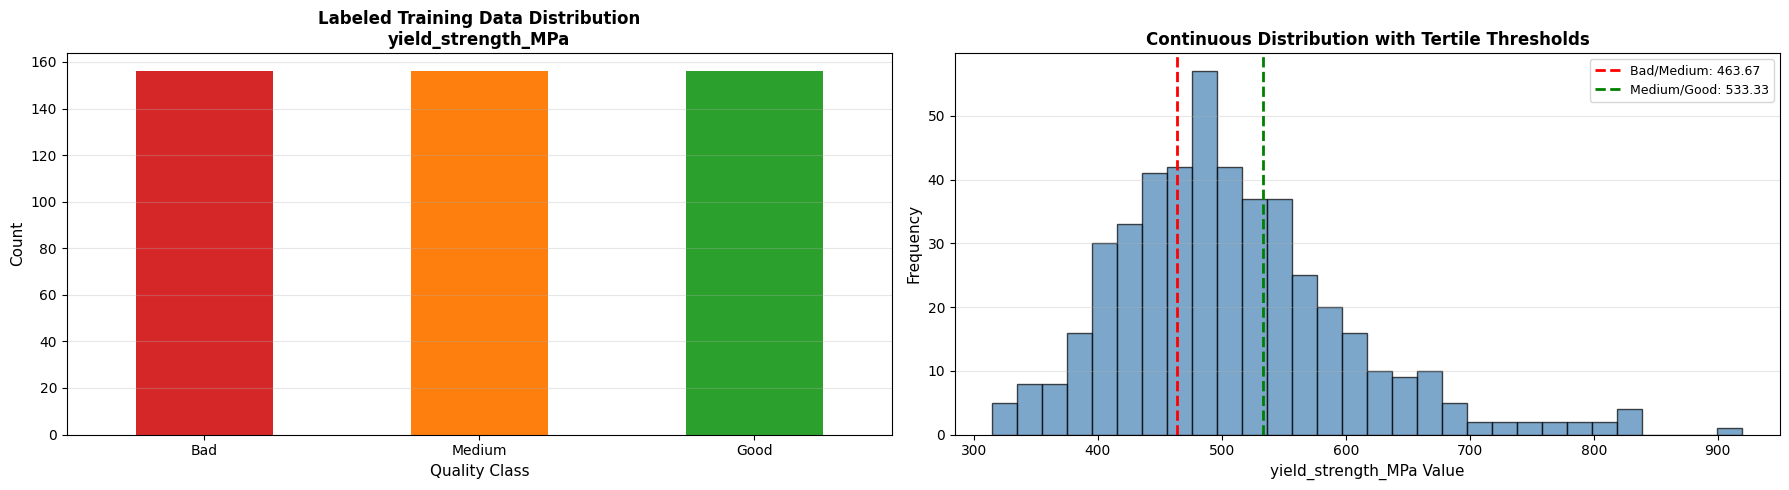

In [17]:
# Check class distribution
labeled_mask = y_train_classes != -1
class_counts = y_train_classes[labeled_mask].value_counts().sort_index()

print(f"\nClass distribution in LABELED training data:")
print(f"  Bad (0):      {class_counts.get(0, 0):4d} samples ({class_counts.get(0, 0)/labeled_mask.sum()*100:.1f}%)")
print(f"  Medium (1):   {class_counts.get(1, 0):4d} samples ({class_counts.get(1, 0)/labeled_mask.sum()*100:.1f}%)")
print(f"  Good (2):     {class_counts.get(2, 0):4d} samples ({class_counts.get(2, 0)/labeled_mask.sum()*100:.1f}%)")
print(f"  Unlabeled:    {(y_train_classes == -1).sum():4d} samples")


# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Bar plot - Labeled distribution
class_counts.plot(kind='bar', ax=axes[0], color=['#d62728', '#ff7f0e', '#2ca02c'])
axes[0].set_xlabel("Quality Class", fontsize=11)
axes[0].set_ylabel("Count", fontsize=11)
axes[0].set_title(f"Labeled Training Data Distribution\n{TARGET_NAME}", fontsize=12, fontweight='bold')
axes[0].set_xticklabels(['Bad', 'Medium', 'Good'], rotation=0)
axes[0].grid(True, alpha=0.3, axis='y')


# Histogram of continuous values with thresholds
labeled_y_train = y_train.dropna()
axes[1].hist(labeled_y_train, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].axvline(threshold_low, color='red', linestyle='--', linewidth=2, label=f'Bad/Medium: {threshold_low:.2f}')
axes[1].axvline(threshold_high, color='green', linestyle='--', linewidth=2, label=f'Medium/Good: {threshold_high:.2f}')
axes[1].set_xlabel(f"{TARGET_NAME} Value", fontsize=11)
axes[1].set_ylabel("Frequency", fontsize=11)
axes[1].set_title(f"Continuous Distribution with Tertile Thresholds", fontsize=12, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 2. SSL - Training

In [19]:
# Define Semi-Supervised Methods

ssl_models = {
    "LabelPropagation": LabelPropagation(
        kernel='rbf',
        gamma=20,
        max_iter=1000,
        tol=1e-3
    ),
    "LabelSpreading": LabelSpreading(
        kernel='rbf',
        gamma=20,
        alpha=0.2,
        max_iter=1000,
        tol=1e-3
    )
}

print("\n" + "=" * 70)
print("SEMI-SUPERVISED MODELS INITIALIZED")
print("=" * 70)
for name, model in ssl_models.items():
    print(f"--> {name}")
print("\nNote: RandomForest will be trained on SSL-propagated labels")


SEMI-SUPERVISED MODELS INITIALIZED
--> LabelPropagation
--> LabelSpreading

Note: RandomForest will be trained on SSL-propagated labels


In [21]:
# Traim SSL Methods

print("\n" + "=" * 70)
print("TRAINING SEMI-SUPERVISED MODELS")
print("=" * 70)

# Store predictions and models
predictions = {}
trained_models = {}

for method_name, model in ssl_models.items():
    print(f"\n[{method_name}]")
    print(f"  Training on {len(y_train_classes)} samples ({(y_train_classes != -1).sum()} labeled, {(y_train_classes == -1).sum()} unlabeled)...")
    
    # Train the SSL model
    model.fit(X_train.values, y_train_classes.values)
    
    # Get propagated labels for training data
    y_train_propagated = model.transduction_
    
    # Predict on validation and test sets
    y_val_pred = model.predict(X_val.values)
    y_test_pred = model.predict(X_test.values)
    
    # Store predictions
    predictions[method_name] = {
        'train': y_train_propagated,
        'val': y_val_pred,
        'test': y_test_pred
    }
    
    trained_models[method_name] = model
    
    # Calculate accuracy on labeled validation data
    val_accuracy = accuracy_score(y_val_classes, y_val_pred)
    print(f"  --> Training completed")
    print(f"  Validation accuracy: {val_accuracy*100:.2f}%")
    print(f"  Labels propagated to {(y_train_classes == -1).sum()} unlabeled samples")

print("\n==> All SSL models trained successfully")


TRAINING SEMI-SUPERVISED MODELS

[LabelPropagation]
  Training on 1340 samples (468 labeled, 872 unlabeled)...
  --> Training completed
  Validation accuracy: 58.97%
  Labels propagated to 872 unlabeled samples

[LabelSpreading]
  Training on 1340 samples (468 labeled, 872 unlabeled)...
  --> Training completed
  Validation accuracy: 58.33%
  Labels propagated to 872 unlabeled samples

==> All SSL models trained successfully


C:\Users\Ouissal\AppData\Roaming\Python\Python312\site-packages\sklearn\semi_supervised\_label_propagation.py:322: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(
C:\Users\Ouissal\AppData\Roaming\Python\Python312\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\Ouissal\AppData\Roaming\Python\Python312\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


In [22]:
# Train random forest with propagated labels

print("\n" + "=" * 70)
print("TRAINING RANDOM FOREST CLASSIFIERS")
print("=" * 70)

rf_models = {}
rf_predictions = {}

for ssl_method in ssl_models.keys():
    print(f"\n[RandomForest with {ssl_method} labels]")
    
    # Use propagated labels from SSL as training data
    y_train_ssl = predictions[ssl_method]['train']
    
    # Train Random Forest on all data with propagated labels
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    
    print(f"  Training RF on {len(y_train_ssl)} samples (all with propagated labels)...")
    rf.fit(X_train.values, y_train_ssl)
    
    # Predict
    y_val_pred_rf = rf.predict(X_val.values)
    y_test_pred_rf = rf.predict(X_test.values)
    
    # Store
    rf_models[ssl_method] = rf
    rf_predictions[ssl_method] = {
        'val': y_val_pred_rf,
        'test': y_test_pred_rf
    }
    
    # Evaluate
    val_accuracy_rf = accuracy_score(y_val_classes, y_val_pred_rf)
    print(f"  --> Training completed")
    print(f"  Validation accuracy: {val_accuracy_rf*100:.2f}%")

print("\n==> All Random Forest models trained successfully")


TRAINING RANDOM FOREST CLASSIFIERS

[RandomForest with LabelPropagation labels]
  Training RF on 1340 samples (all with propagated labels)...
  --> Training completed
  Validation accuracy: 60.90%

[RandomForest with LabelSpreading labels]
  Training RF on 1340 samples (all with propagated labels)...
  --> Training completed
  Validation accuracy: 63.46%

==> All Random Forest models trained successfully


## 3. Evaluation

In [25]:
# evaluate all models

print("\n" + "=" * 70)
print("MODEL EVALUATION SUMMARY")
print("=" * 70)

results = []

# Evaluate SSL models
for method_name in ssl_models.keys():
    val_acc = accuracy_score(y_val_classes, predictions[method_name]['val'])
    test_acc = accuracy_score(y_test_classes, predictions[method_name]['test'])
    
    results.append({
        'Model': method_name,
        'Validation Accuracy': f"{val_acc*100:.2f}%",
        'Test Accuracy': f"{test_acc*100:.2f}%"
    })

# Evaluate RF models
for method_name in rf_models.keys():
    val_acc = accuracy_score(y_val_classes, rf_predictions[method_name]['val'])
    test_acc = accuracy_score(y_test_classes, rf_predictions[method_name]['test'])
    
    results.append({
        'Model': f"RF + {method_name}",
        'Validation Accuracy': f"{val_acc*100:.2f}%",
        'Test Accuracy': f"{test_acc*100:.2f}%"
    })

# Display results
results_df = pd.DataFrame(results)
print("\n")
print(results_df.to_string(index=False))
print("\n" + "=" * 70)


MODEL EVALUATION SUMMARY


                Model Validation Accuracy Test Accuracy
     LabelPropagation              58.97%        67.95%
       LabelSpreading              58.33%        68.59%
RF + LabelPropagation              60.90%        67.31%
  RF + LabelSpreading              63.46%        66.67%




DETAILED EVALUATION: BEST MODELS

Best SSL Model: LabelPropagation
Best RF Model:  RF + LabelSpreading

BEST SSL MODEL: LabelPropagation

Test Accuracy: 67.95%

Classification Report:
              precision    recall  f1-score   support

         Bad       0.61      0.77      0.68        43
      Medium       0.71      0.61      0.65        59
        Good       0.73      0.69      0.70        54

    accuracy                           0.68       156
   macro avg       0.68      0.69      0.68       156
weighted avg       0.69      0.68      0.68       156



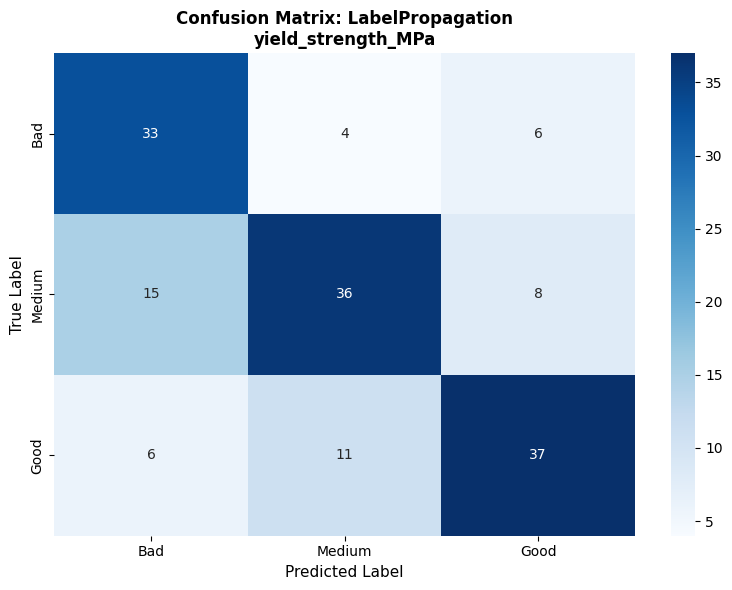


BEST RF MODEL: RF + LabelSpreading

Test Accuracy: 66.67%

Classification Report:
              precision    recall  f1-score   support

         Bad       0.56      0.77      0.65        43
      Medium       0.68      0.54      0.60        59
        Good       0.78      0.72      0.75        54

    accuracy                           0.67       156
   macro avg       0.67      0.68      0.67       156
weighted avg       0.68      0.67      0.67       156



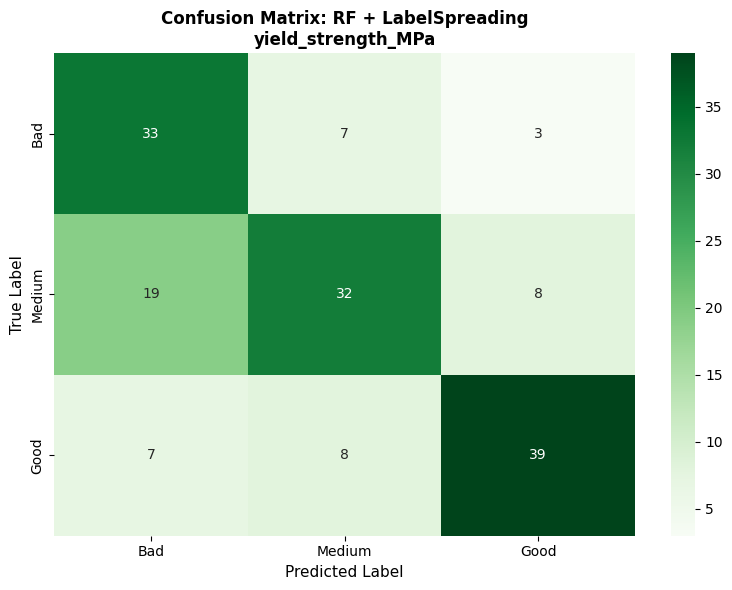


Top 10 Most Important Features (RF + LabelSpreading):
feature  importance
    PC3    0.079874
   PC14    0.070190
    PC9    0.065389
   PC13    0.064916
    PC6    0.062658
    PC4    0.061326
   PC10    0.054687
    PC1    0.054619
    PC8    0.054483
   PC16    0.052039


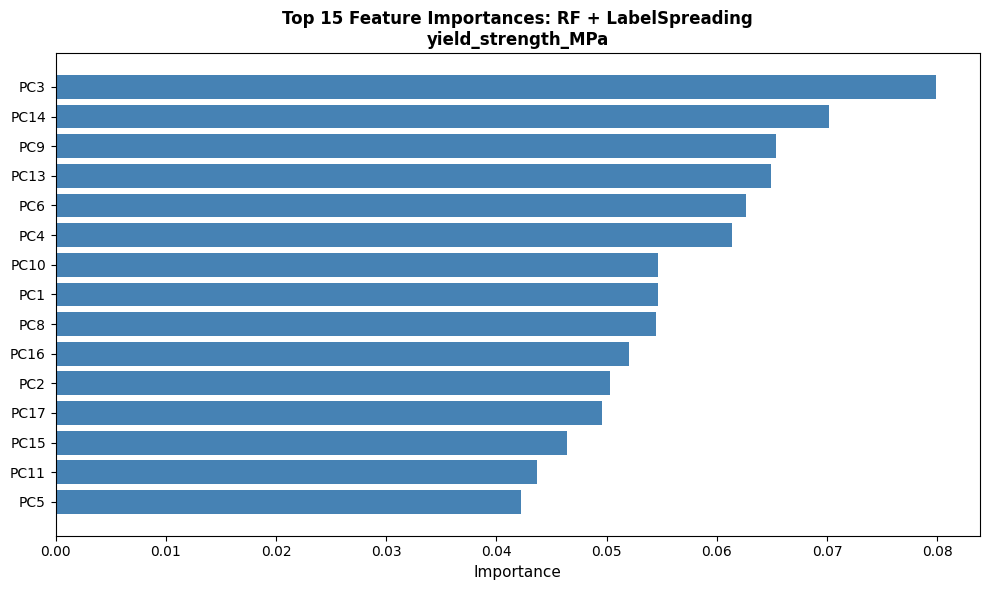

In [26]:
# Detailed evaluation - select best model

# Select best model based on validation accuracy
best_ssl_method = max(ssl_models.keys(), 
                      key=lambda x: accuracy_score(y_val_classes, predictions[x]['val']))
best_rf_method = max(rf_models.keys(), 
                     key=lambda x: accuracy_score(y_val_classes, rf_predictions[x]['val']))

print("\n" + "=" * 70)
print(f"DETAILED EVALUATION: BEST MODELS")
print("=" * 70)
print(f"\nBest SSL Model: {best_ssl_method}")
print(f"Best RF Model:  RF + {best_rf_method}")

# Evaluate best SSL model
print(f"\n{'='*70}")
print(f"BEST SSL MODEL: {best_ssl_method}")
print(f"{'='*70}")

y_test_pred_best_ssl = predictions[best_ssl_method]['test']
test_acc_ssl = accuracy_score(y_test_classes, y_test_pred_best_ssl)

print(f"\nTest Accuracy: {test_acc_ssl*100:.2f}%")
print(f"\nClassification Report:")
print(classification_report(y_test_classes, y_test_pred_best_ssl, 
                          target_names=['Bad', 'Medium', 'Good'],
                          zero_division=0))

# Confusion matrix
cm_ssl = confusion_matrix(y_test_classes, y_test_pred_best_ssl)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ssl, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bad', 'Medium', 'Good'],
            yticklabels=['Bad', 'Medium', 'Good'])
plt.title(f'Confusion Matrix: {best_ssl_method}\n{TARGET_NAME}', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=11)
plt.xlabel('Predicted Label', fontsize=11)
plt.tight_layout()
plt.show()

# Evaluate best RF model
print(f"\n{'='*70}")
print(f"BEST RF MODEL: RF + {best_rf_method}")
print(f"{'='*70}")

y_test_pred_best_rf = rf_predictions[best_rf_method]['test']
test_acc_rf = accuracy_score(y_test_classes, y_test_pred_best_rf)

print(f"\nTest Accuracy: {test_acc_rf*100:.2f}%")
print(f"\nClassification Report:")
print(classification_report(y_test_classes, y_test_pred_best_rf, 
                          target_names=['Bad', 'Medium', 'Good'],
                          zero_division=0))

# Confusion matrix
cm_rf = confusion_matrix(y_test_classes, y_test_pred_best_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Bad', 'Medium', 'Good'],
            yticklabels=['Bad', 'Medium', 'Good'])
plt.title(f'Confusion Matrix: RF + {best_rf_method}\n{TARGET_NAME}', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=11)
plt.xlabel('Predicted Label', fontsize=11)
plt.tight_layout()
plt.show()

# Feature importance for best RF
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_models[best_rf_method].feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Most Important Features (RF + {best_rf_method}):")
print(feature_importance.head(10).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importance', fontsize=11)
plt.title(f'Top 15 Feature Importances: RF + {best_rf_method}\n{TARGET_NAME}', 
          fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 4. Save results

In [27]:
# Save SSL results

from pathlib import Path

# Create results directory
results_dir = project_root / "results" / "ssl_results" / TARGET_NAME
results_dir.mkdir(parents=True, exist_ok=True)

print("\n" + "=" * 70)
print("SAVING RESULTS")
print("=" * 70)

# Save all predictions
for method_name in ssl_models.keys():
    # SSL predictions
    pd.DataFrame({
        'true': y_test_classes,
        'predicted': predictions[method_name]['test']
    }).to_csv(results_dir / f"{method_name}_predictions.csv", index=False)
    
    # RF predictions
    pd.DataFrame({
        'true': y_test_classes,
        'predicted': rf_predictions[method_name]['test']
    }).to_csv(results_dir / f"RF_{method_name}_predictions.csv", index=False)

# Save results summary
results_df.to_csv(results_dir / "model_comparison.csv", index=False)

# Save feature importance
if DATA_VERSION == "clean":
    feature_importance.to_csv(results_dir / "feature_importance.csv", index=False)

# Save thresholds for reproducibility
pd.DataFrame({
    'threshold_type': ['Bad/Medium (33.3%)', 'Medium/Good (66.6%)'],
    'value': [threshold_low, threshold_high]
}).to_csv(results_dir / "quality_thresholds.csv", index=False)

print(f"\n✓ Results saved to: {results_dir}/")
print(f"  - Model predictions (CSV)")
print(f"  - Model comparison (CSV)")
print(f"  - Quality thresholds (CSV)")
if DATA_VERSION == "clean":
    print(f"  - Feature importance (CSV)")
print("\n" + "=" * 70)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("=" * 70)


SAVING RESULTS

✓ Results saved to: c:\Users\Ouissal\weld-quality\results\ssl_results\yield_strength_MPa/
  - Model predictions (CSV)
  - Model comparison (CSV)
  - Quality thresholds (CSV)

PIPELINE COMPLETED SUCCESSFULLY!
